---
title: "Image classification"
format: 
  html:
    code-fold: true
jupyter: python3
---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/satellite-image-deep-learning/course/blob/main/02-classification.ipynb)

## Image classification
You may already be familiar with image classification from seeing the numerous cats vs dogs image classification tutorials on the internet. Image classification is therefore the task of assigning one (or more) labels to an entire image. When applied to satellite imagery, classification has two common uses:

- label the subject of image, e.g. golf course, harbour
- perform detection of some subject, e.g. ship present or not

There are also more advanced classification techniques, for example using a time-series of images to classify crops where the unique seasonal changes are a strong indicator of crop type.

## Image classification datasets
To get more familiar with satellite image classification start by exploring a couple of benchmark datasets. A benchmark dataset is a dataset that is used as a standard by the community to compare the performance of different techniques. Two good benchmark datasets are the UC Merced dataset (a sample of which is shown below) or the EuroSAT dataset. Both of these datasets are available in the standard RGB/single label format, but also in more interesting multi-class versions.

<p align="center">
  <img src="images/classification-main.png" width="600" />
</p>


### EuroSAT
Lets download and view the EuroSAT dataset which is available in Torchvision

In [24]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # Issue https://github.com/pytorch/vision/issues/5039

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, utils, transforms, models
import torchvision.transforms.functional as F

import time
import os
import copy

dataset = datasets.EuroSAT(
    root="/tmp",
    transform=transforms.ToTensor(),
    download=True
)

In [25]:
dataset

Dataset EuroSAT
    Number of datapoints: 27000
    Root location: /tmp
    StandardTransform
Transform: ToTensor()

We can access single images from the dataset, and see it is a 3 channel (RGB) image of shape 64 x 64 pixels. Labels are encoded as integers:

In [26]:
img, label = dataset[0]
img.size(), label

(torch.Size([3, 64, 64]), 0)

Visualise the single image

Text(0.5, 1.0, '0')

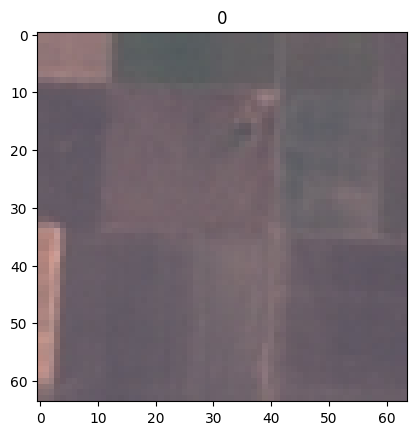

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(F.to_pil_image(img))
ax.set_title(label)

To create batches of images (as is typical when training models) we must first create a dataloader from the dataset:

In [28]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4)

Return the first batch of images and visualise

In [29]:
x, y = next(iter(data_loader))

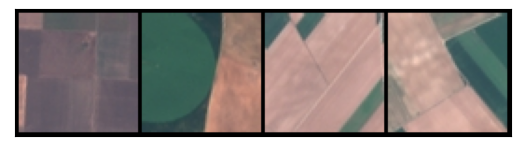

In [30]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

show(utils.make_grid(x))

## Fine tuning models
It is relatively rare to train a model from scratch on a custom dataset, and far more common to use a model that has been pre-trained on a benchmark dataset (usually ImageNet) and then fine-tune this model on the custom dataset. To learn more about fine-tuning read the [fine-tuning lesson on d2l.ai](https://d2l.ai/chapter_computer-vision/fine-tuning.html). In fine-tuning the feature extraction layers are frozen, and only the fully connected classification layers are updated:

Show https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html on our dataset, will be slow on CPU. This dataset does not have train and val split

## SOTA models
The internet regularly reports new 'state of the art' (SOTA) models which improve performance on some benchmark dataset or other, and it would be reasonable to assume that the latest and greatest models are usually used in applications. In the article [The best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning/notebook) author Jeremy Howard compares 86 classification models on two benchmark datasets; the IIT Pet dataset and the Kaggle Planet dataset (a remote sensing dataset). Jeremy shows that the modern models are the top performers in terms of accuracy, shown in the table below:

<p align="center">
  <img src="images/classification-table.png" width="600" />
</p>

Interestingly the best performers vary between the Pets and Planet datasets, and Jeremy attributes this to the fact that the Planet dataset does not resemble the images in the ImageNet dataset (which most models are pre-trained on), so the models which learn new features the fastest are the best performers. He also notes that "there's little correlation between model size and performance" on the Planet dataset, and therefore advises selecting smaller models (which will also be faster in use). An additional advantage of choosing a small model is that the pace of experimentation is faster. A surprising result on the Planet dataset is that the relatively old (2015) Resnet 18 model is in the top 10 performers. As Jeremy says, "Resnet 18 has very low memory use, is fast, and is still quite accurate", and for these reasons I suggest it is a good default model to begin projects with.